In [1]:
import json
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
additional_stopwords = ["exemple", "problème", "fois", "monde", "foi", "temps",
                        "moment", "jour", "coup", "truc", "côté", "besoin", "ouai", "sen",
                        "faire", "chose","cas", "fois", "temps", "monde", "ouais", "coup", "chose","choses","truc",
                 "moment", "musique", "france", "côté", "fin", "partie", "point", "part", "ans",
                 "monsieur",
                 "être", "etre", "ok", "mot", "idée", "merde", "bout", "soir", "pari",
                 "grâce", "ville", "parti", "discours"]

In [3]:
stopword_french = stopwords.words('french')
stopword_english = stopwords.words('english')
stopword = stopword_french + stopword_english
stopword = set(stopword)
stopword.update(additional_stopwords)

In [4]:
file_path = "../../SpaCy_fr_preprocessed_transcripts_all_years.jsonl"
data = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line.strip()))

In [5]:
docs = []
for d in tqdm(data):
    transcript = ' '.join(d["processed_transcripts"])
    docs.append(transcript)

  0%|          | 0/15527 [00:00<?, ?it/s]

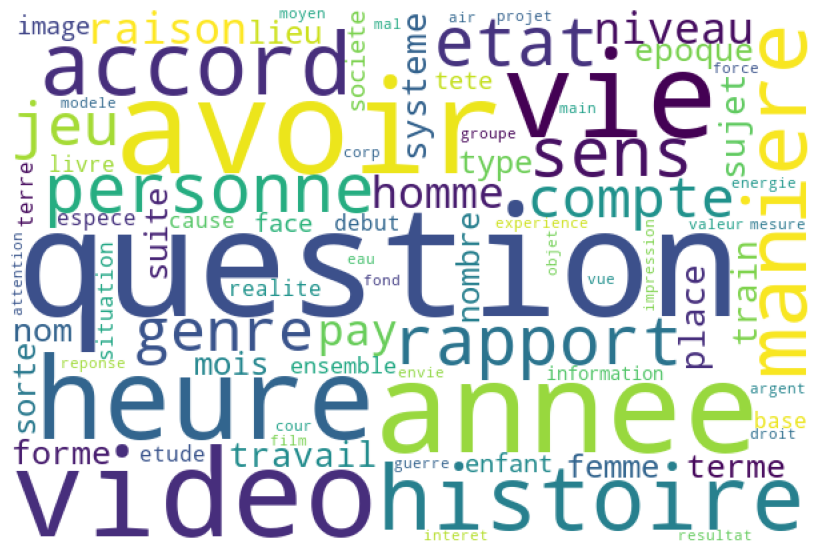

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

text = ' '.join(docs)

wordcloud = WordCloud(width = 600, height = 400, 
                background_color ='white', 
                stopwords = stopword, 
                min_font_size = 10).generate(text)

# Plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [7]:
import collections
from tqdm import tqdm

# Construction du vocabulaire
all_vocab = collections.Counter()
tokenizer = CountVectorizer(stop_words=stopword).build_tokenizer()
for doc in tqdm(docs):
  all_vocab.update(tokenizer(doc.lower()))

100%|██████████| 15527/15527 [00:05<00:00, 2763.15it/s]


In [8]:
len(all_vocab)

1198358

In [9]:
vocab = [word.lower() for word, frequency in all_vocab.items() if frequency >= 15 and frequency < 9000]
print(len(vocab))

50318


In [10]:
to_add = [word for word, frequency in all_vocab.items() if frequency >= 10000 or frequency < 15]
stopword.update(to_add)

In [11]:
vectorizer = CountVectorizer(stop_words=list(stopword),
                             max_features=20000,
                             max_df=0.95, min_df=2,
                             vocabulary=vocab, 
                             ngram_range=(1, 3))

In [12]:
tf_idf = vectorizer.fit_transform([" ".join(d['processed_transcripts']) for d in data])

In [13]:
lda_model = LatentDirichletAllocation(n_components=25, learning_method='online',
                                      max_iter=8, random_state=0,
                                      learning_offset=50,
                                      n_jobs=-1)
lda_top = lda_model.fit_transform(tf_idf)

In [14]:
def get_topics(vectorizer, lda_model, n_top_words=10):
    feature_names = vectorizer.get_feature_names_out()
    topics = []
    for topic_idx, topic in enumerate(lda_model.components_):
        topics.append(" ".join([feature_names[i]
                                for i in topic.argsort()[:-n_top_words - 1:-1]]))
    return topics

- We can plot the top words for each topic.
- Source: [scikit-learn](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)
- Try to add metrics: [OCTIS](https://github.com/MIND-Lab/OCTIS)
- [gensim coherence metric](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)
- [Bertopic metrics discussion](https://github.com/MaartenGr/BERTopic/issues/428)
- [292](https://github.com/MaartenGr/BERTopic/issues/292)
- [OTMISC-Topic-Modeling-Tool](https://github.com/berksudan/OTMISC-Topic-Modeling-Tool)

In [15]:
def compute_top_words_sklearn(model, feature_names, n_top_words):
    """
    Compute the top words for each topic
    """
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        topics.append((top_features, weights))
    return topics

In [16]:
def plot_top_words(topics, title):
    """
    Plot the top words for each topic
    """
    col = 5
    topic_num = len(topics)
    topic_num_col_ratio = topic_num//col
    row = topic_num_col_ratio if topic_num%col == 0 else topic_num_col_ratio + 1
    fig, axes = plt.subplots(row, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, (top_features, weights) in enumerate(topics):
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [17]:
topics = compute_top_words_sklearn(lda_model,
                                   feature_names=vectorizer.get_feature_names_out(), n_top_words=10)

In [19]:
topics_words = get_topics(vectorizer, lda_model, n_top_words=10)

In [22]:
from tournesol_topics.evaluation import evaluator
from tournesol_topics.types import TopicInfo

topics_info = TopicInfo(topics=[words.split() for words in topics_words],
                        docs=[doc.split() for doc in docs])

evaluator(topics_info)

{'coherence_cv': 0.6180368140645799,
 'coherence_npmi': 0.08869312531782018,
 'diversity': 0.948}

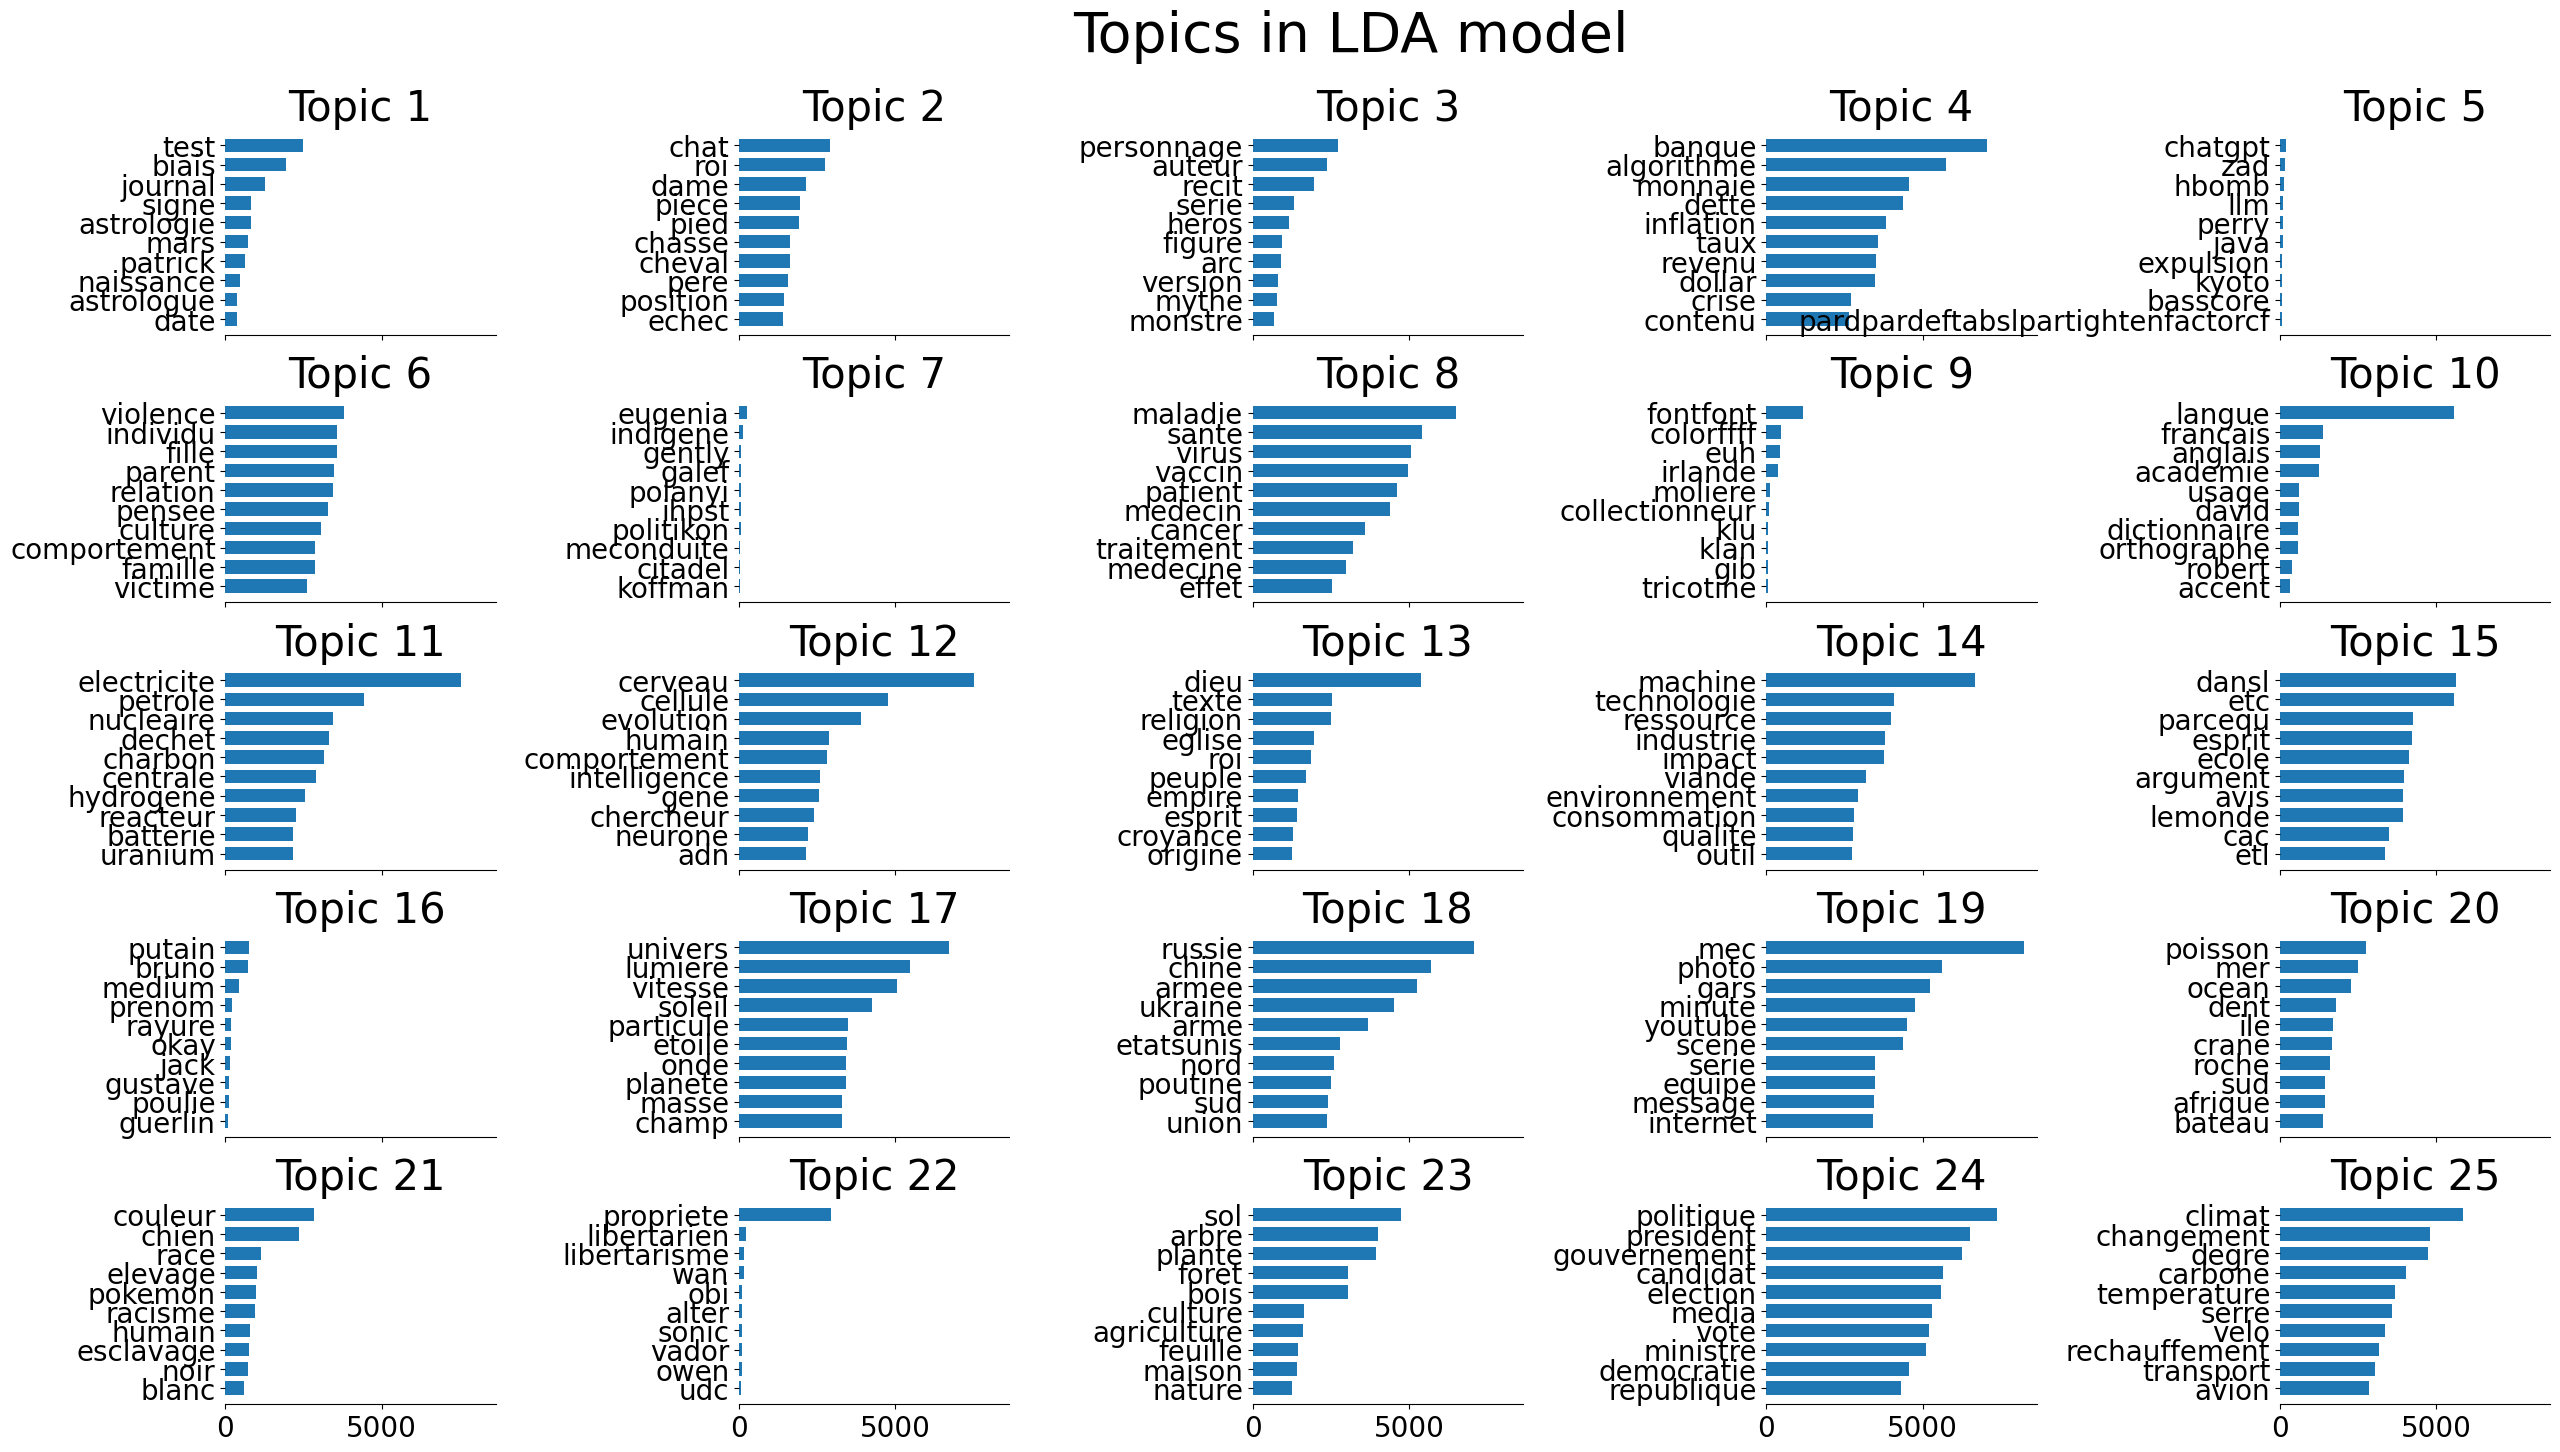

In [ ]:
plot_top_words(topics, title="Topics in LDA model")


In [ ]:
topics = get_topics(vectorizer, lda_model)

['test biais journal signe astrologie mars patrick naissance astrologue date',
 'chat roi dame piece pied chasse cheval pere position echec',
 'personnage auteur recit serie heros figure arc version mythe monstre',
 'banque algorithme monnaie dette inflation taux revenu dollar crise contenu',
 'chatgpt zad hbomb llm perry java expulsion kyoto basscore pardpardeftabslpartightenfactorcf',
 'violence individu fille parent relation pensee culture comportement famille victime',
 'eugenia indigene gently galef polanyi ihpst politikon meconduite citadel koffman',
 'maladie sante virus vaccin patient medecin cancer traitement medecine effet',
 'fontfont colorffff euh irlande moliere collectionneur klu klan gib tricotine',
 'langue francais anglais academie usage david dictionnaire orthographe robert accent',
 'electricite petrole nucleaire dechet charbon centrale hydrogene reacteur batterie uranium',
 'cerveau cellule evolution humain comportement intelligence gene chercheur neurone adn',
 'di

## Gensim

In [23]:
from gensim.corpora import Dictionary

In [24]:
dictionnary = Dictionary([d['processed_transcripts'] for d in data])

In [25]:
dictionnary.filter_extremes(no_below=15, no_above=0.25)

In [26]:
corpus = [dictionnary.doc2bow(d['processed_transcripts']) for d in data]

In [27]:
from gensim.models import LdaMulticore


gensim_lda_model = LdaMulticore(corpus=corpus, id2word=dictionnary, num_topics=10,
                         workers=3, chunksize=100, passes=10, per_word_topics=True)

In [24]:
from pprint import pprint
# Print the Keywords in the 10 topics
pprint(gensim_lda_model.print_topics())

[(0,
  '0.004*"dansl" + 0.004*"etc" + 0.003*"parcequ" + 0.003*"cac" + '
  '0.002*"lemonde" + 0.002*"etl" + 0.002*"etd" + 0.002*"ecole" + 0.002*"onn" + '
  '0.002*"avis"'),
 (1,
  '0.013*"droite" + 0.012*"gauche" + 0.009*"loi" + 0.008*"president" + '
  '0.008*"politique" + 0.007*"gouvernement" + 0.007*"media" + 0.007*"election" '
  '+ 0.007*"candidat" + 0.007*"vote"'),
 (2,
  '0.008*"donnee" + 0.008*"science" + 0.006*"article" + 0.006*"algorithme" + '
  '0.005*"theorie" + 0.005*"argument" + 0.005*"risque" + 0.005*"contenu" + '
  '0.005*"comportement" + 0.005*"cerveau"'),
 (3,
  '0.022*"guerre" + 0.010*"siecle" + 0.009*"russie" + 0.007*"chine" + '
  '0.007*"europe" + 0.007*"armee" + 0.006*"population" + 0.006*"ukraine" + '
  '0.006*"arme" + 0.005*"etatsunis"'),
 (4,
  '0.012*"espace" + 0.012*"univers" + 0.011*"objet" + 0.010*"theorie" + '
  '0.010*"lumiere" + 0.008*"vitesse" + 0.007*"soleil" + 0.007*"particule" + '
  '0.007*"onde" + 0.007*"champ"'),
 (5,
  '0.028*"euro" + 0.026*"entrepri

In [25]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(gensim_lda_model, corpus, dictionnary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.157029 -0.210084       1        1  22.167126
2      0.028436  0.038778       2        1  14.257668
8      0.155884 -0.119888       3        1  13.183938
1      0.188064  0.146793       4        1   9.198090
3      0.112666  0.128524       5        1   8.909840
7     -0.237116  0.104562       6        1   7.007157
4     -0.138105 -0.094571       7        1   6.979721
9     -0.140817 -0.169760       8        1   6.475933
5     -0.030797  0.202419       9        1   6.126732
6     -0.095244 -0.026772      10        1   5.693795, topic_info=            Term          Freq         Total Category  logprob  loglift
726      energie  24359.000000  24359.000000  Default  30.0000  30.0000
416         euro  18004.000000  18004.000000  Default  29.0000  29.0000
405   entreprise  15752.000000  15752.000000  Default  28.0000  28.0000
245       guerre  18506.000000  18506.000000  Default  27.0000  27.0000
154       animal  12956.000000  12956.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
4464       ocean   1498.534940   3428.528417  Topic10  -5.7762   2.0381
2815        pied   1765.058761   6312.432709  Topic10  -5.6125   1.5915
14        espace   2066.835449  12911.087897  Topic10  -5.4547   1.0337
6         centre   1536.868951   7658.069548  Topic10  -5.7509   1.2598
1530    securite   1512.948906   6679.107156  Topic10  -5.7666   1.3809

[788 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
7276      4  0.998130  abstention
328       1  0.100682       achat
328       2  0.006330       achat
328       4  0.066317       achat
328       6  0.046724       achat
...     ...       ...         ...
2139      6  0.043950        zone
2139      7  0.126500        zone
2139      8  0.128602        zone
2139      9  0.072900        zone
2139     10  0.476382        zone

[2730 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 9, 2, 4, 8, 5, 10, 6, 7])

In [28]:
def compute_top_words_gensim(model, n_top_words):
    """
    Compute the top words for each topic
    """
    topics = []
    for topic_idx in range(len(model.get_topics())):
        topic = model.show_topic(topic_idx, topn=n_top_words)
        topic = sorted(topic, key=lambda x: x[1], reverse=False)
        top_features = [word_id for word_id, _ in topic]
        weights = [prob for _, prob in topic]
        topics.append((top_features, weights))
    return topics

In [29]:
gensim_topics = compute_top_words_gensim(gensim_lda_model, n_top_words=10)

In [31]:
gensim_words_topics = [words for words, _ in gensim_topics]
gensim_words_topics

[['onde',
  'energie',
  'soleil',
  'particule',
  'theorie',
  'lumiere',
  'vitesse',
  'objet',
  'univers',
  'espace'],
 ['equipe',
  'journee',
  'mode',
  'plaisir',
  'fille',
  'maison',
  'youtube',
  'photo',
  'gars',
  'mec'],
 ['decette',
  'cac',
  'etd',
  'lemonde',
  'parcequ',
  'livre',
  'etl',
  'etc',
  'vaccin',
  'dansl'],
 ['consommation',
  'impact',
  'petrole',
  'carbone',
  'electricite',
  'emission',
  'voiture',
  'gaz',
  'production',
  'energie'],
 ['poisson',
  'evolution',
  'virus',
  'zone',
  'plante',
  'arbre',
  'sol',
  'cellule',
  'espece',
  'animal'],
 ['episode',
  'oeuvre',
  'serie',
  'siecle',
  'personnage',
  'livre',
  'dieu',
  'langue',
  'the',
  'film'],
 ['economie',
  'produit',
  'dette',
  'machine',
  'milliard',
  'banque',
  'algorithme',
  'donnee',
  'euro',
  'entreprise'],
 ['debat',
  'francais',
  'media',
  'pouvoir',
  'president',
  'gouvernement',
  'loi',
  'politique',
  'droite',
  'gauche'],
 ['maladie'

In [36]:
from gensim.models import CoherenceModel

coherence = CoherenceModel(topics=gensim_words_topics,
                           texts=[doc.split() for doc in docs],
                           coherence='c_v',
                           dictionary=dictionnary)
coherence.get_coherence()

0.574268668296396

In [37]:
gensim_topics_info = TopicInfo(topics=gensim_words_topics,
                               docs=[doc.split() for doc in docs])
gensim_metrics = evaluator(gensim_topics_info)
gensim_metrics

{'coherence_cv': 0.574268668296396,
 'coherence_npmi': 0.08187695010633626,
 'diversity': 0.97}

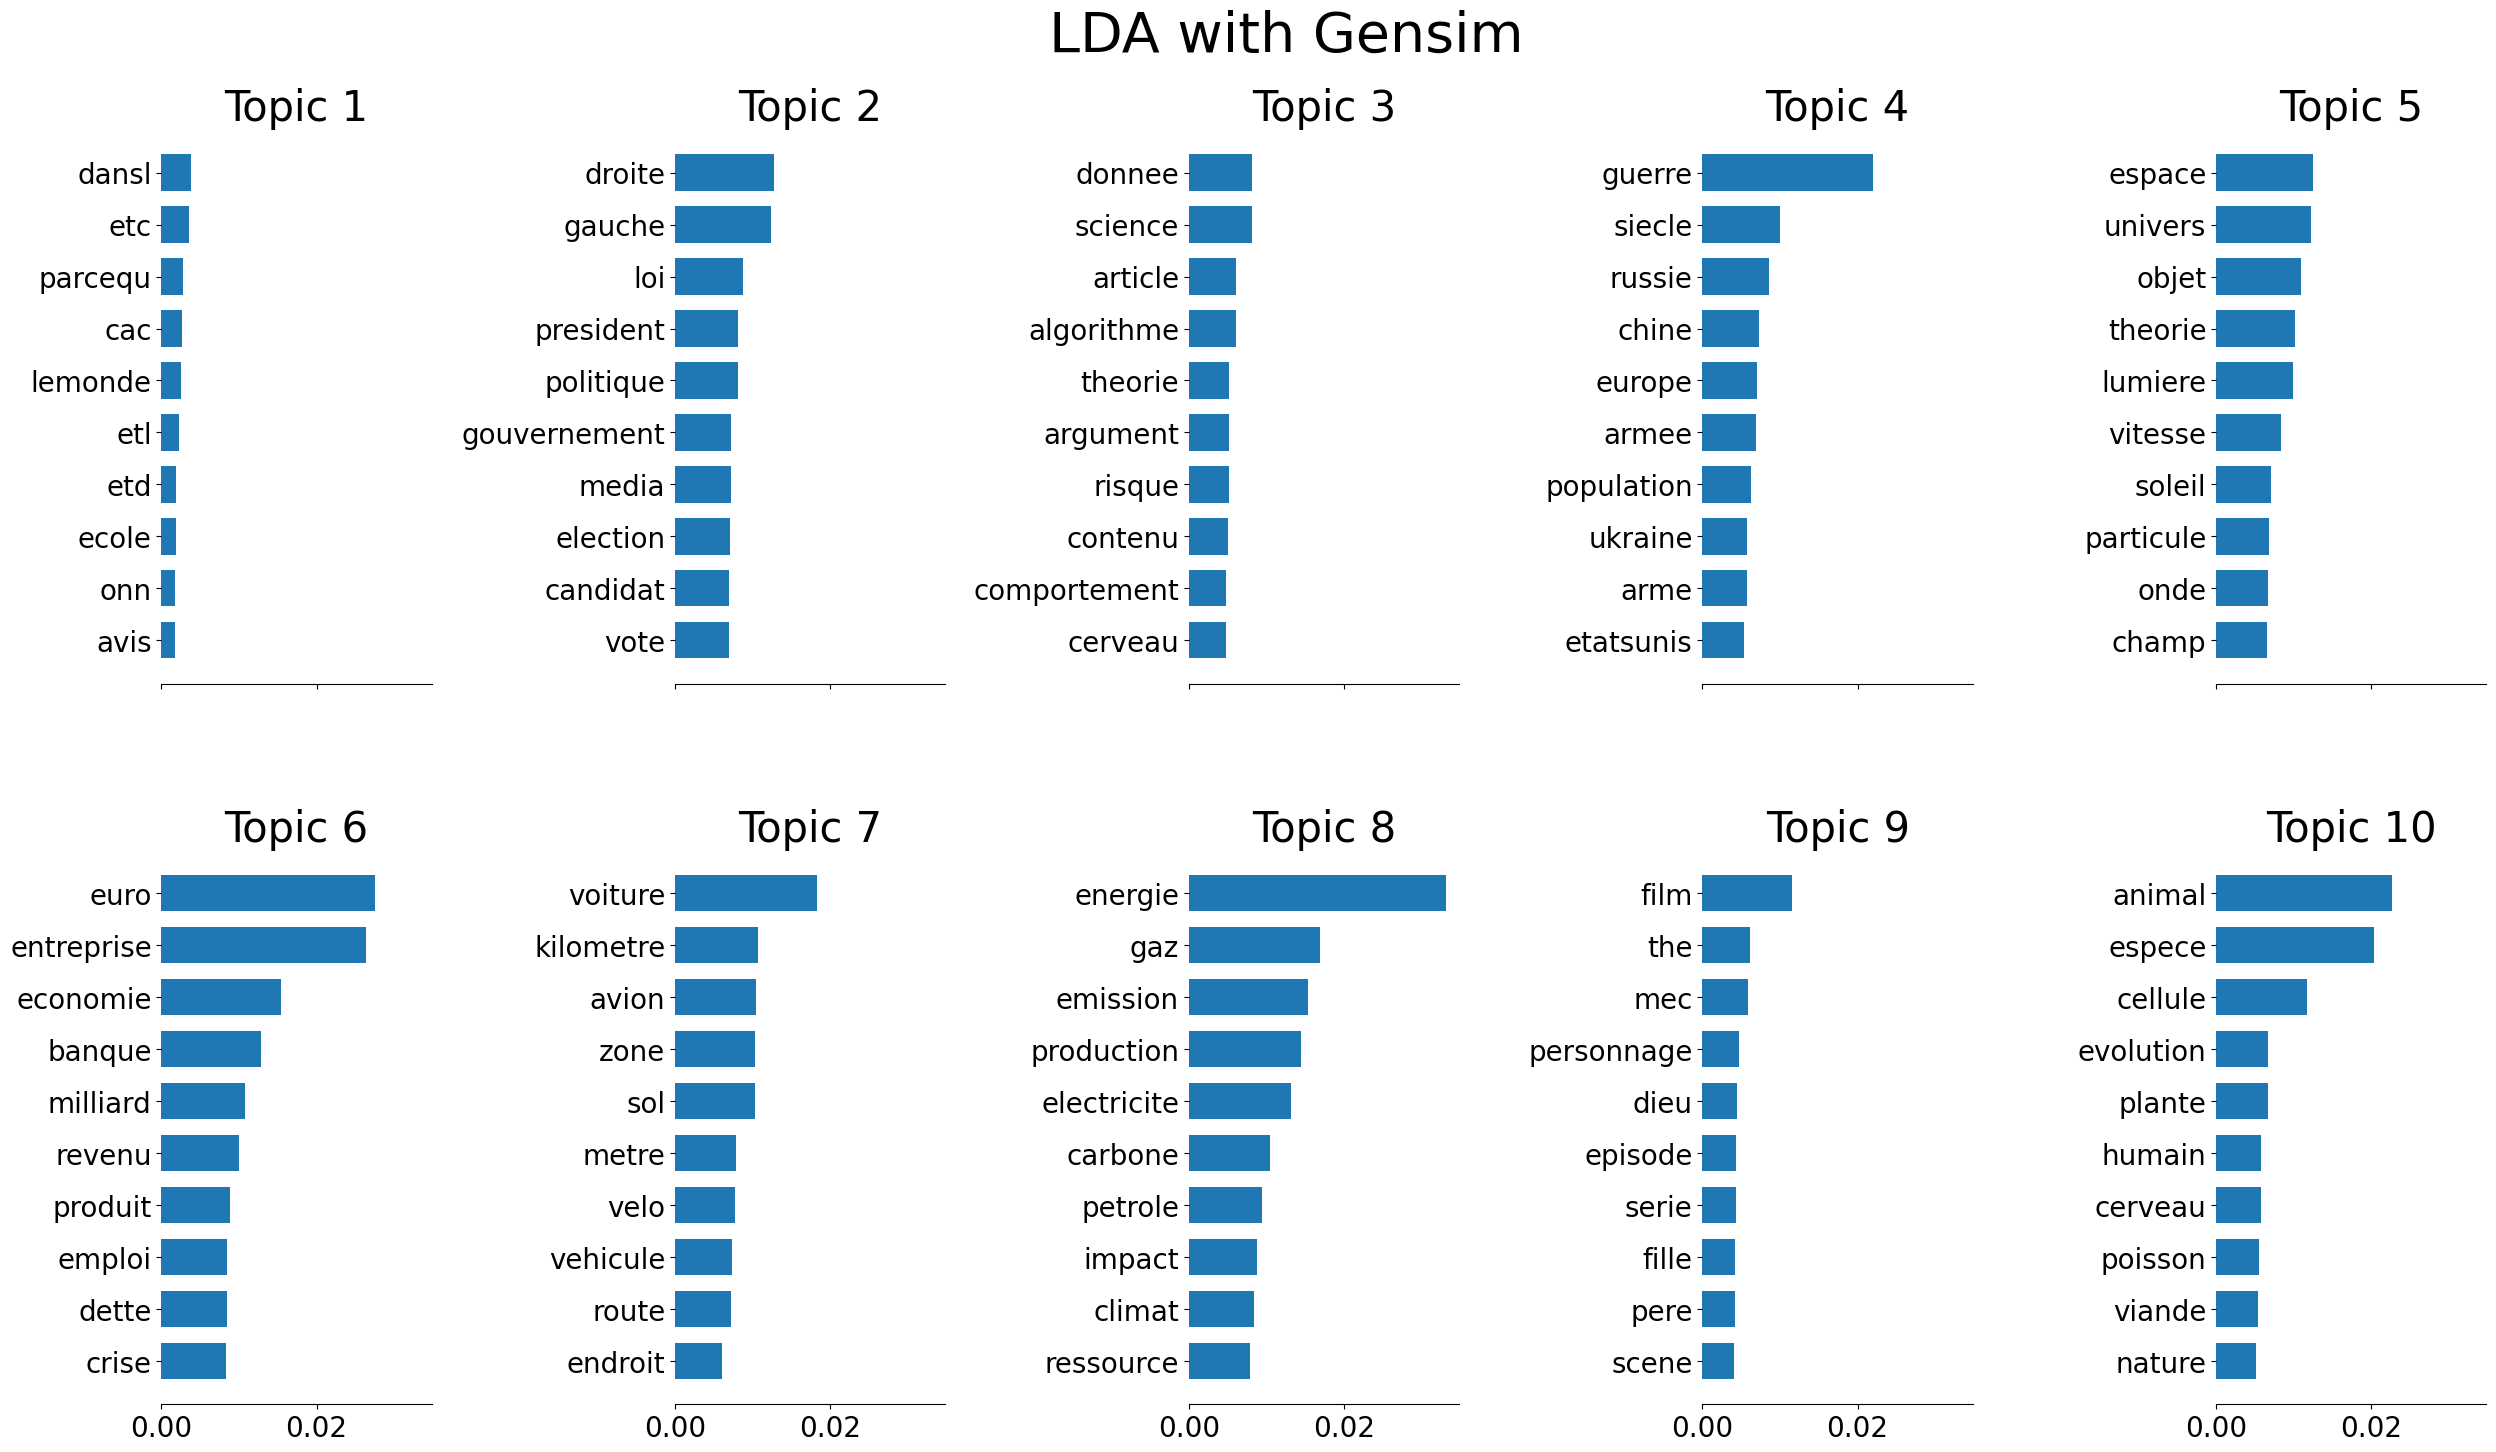

In [27]:
topics = compute_top_words_gensim(gensim_lda_model, n_top_words=10)
plot_top_words(topics, "LDA with Gensim")

## Tuning parameters

In [31]:
import gensim
from gensim.models import CoherenceModel
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import pandas as pd
import tqdm


grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 8
max_topics = 20
step_size = 3
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [corpus]

corpus_title = ['100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionnary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()